# FiveThirtyEight Riddler: Marathon Running Buddies
https://fivethirtyeight.com/features/how-hard-is-it-to-find-a-running-buddy/

This is a tough one, especially if you interpret it as I think it's intended. That is: find the number of runners $N$ such that the whole group has a 1% chance of containing a buddy-less runner. This is harder than the alternative reading of the question, i.e. find the number of runners $N$ such that any given one of them has a 99% chance of having a buddy (which is a softer requirement).

I'll try a few things in this notebook, including some brute-force simulations, an attempt at an analytic description, and some curve-fitting to the MC data. 

### Import libraries

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.stats import norm
from scipy.optimize import curve_fit
import time
%matplotlib inline

### Define simulation functions

In [3]:
# check if array contains a value isolated by a distance more than s from nearest neighbors
def has_buddyless(speeds, s):
    speeds.sort()
    diffs = np.diff(speeds)
    diffs_bool = diffs > s
    if np.any(diffs_bool):
        if diffs_bool[0] or diffs_bool[-1]:
            return True
        if np.any(diffs_bool[:-1] & diffs_bool[1:]):
            return True
    return False

# simulate a bunch of runner groups, find fraction containing a buddy-less runner
def probs_mc(s_over_sig, n_vals, n_trials=1000, sigma = 1, mu = 0, sample_size=None):
    s = s_over_sig * sigma
    probs = np.zeros_like(n_vals,dtype=float)
    
    # don't try to do too much
    max_sample_size = int(4e8)
    if sample_size is None:
        sample_size = np.min([max_sample_size,np.max(n_vals)*n_trials])
    else:
        sample_size = np.min([max_sample_size,sample_size])
        
    print('Simulating '+str(sample_size)+' total runners')
    speeds_pool = norm.rvs(loc=mu, scale=sigma, size=sample_size)
    print('Done simulating runners. Breaking up into trials.')
    
    # Loop over input N values, counting number of ensembles that contain a buddy-less runner
    for n_idx,n in enumerate(n_vals):
        num_buddyless = 0
        
        # case 1: plenty of MC to go around
        if n_trials*n <= sample_size:
            all_speeds = np.random.choice(speeds_pool,(n_trials,n),replace=False)
            for trial in range(n_trials):
                speeds = all_speeds[trial]
                if has_buddyless(speeds, s):
                    num_buddyless += 1
                    
        # case 2: need to chunk the trial generation for memory usage
        else:
            n_over_sample = float(n)/sample_size
            if n_over_sample > 1:
                print('Error: N is larger than max number of MC samples')
                return probs
            
            print('Warning: bootstrapping to get desired # trials')
                
            # 
            num_trials_done = 0
            while num_trials_done < n_trials:
                n_trials_chunk = np.min([sample_size//n, n_trials-num_trials_done])
                print('chunk size = '+str(n_trials_chunk))
                all_speeds = np.random.choice(speeds_pool,(n_trials_chunk,n),replace=False)
                for trial in range(n_trials_chunk):
                    speeds = all_speeds[trial]
                    if has_buddyless(speeds, s):
                        num_buddyless += 1
                num_trials_done += n_trials_chunk
        probs[n_idx] = float(num_buddyless) / float(n_trials)      
    return probs

## Run some sims
WLOG, we can take the runner speed distrubution to be standard normal, with the only free parameters of the problem being the number of runners $N$ and the threshold size of the buddy condition relative to the st. dev. $s/\sigma$.

Let's try a few values of $s/\sigma$ between .1 and 1. I'd expect 1 to be on the large side, but as we'll see, this still requires a large $N$ to get a small chance of buddy-less runners. We'll scan over $N \in [2,40000]$

In [4]:
n_vals = np.unique(np.rint(2*np.logspace(0,4.3,40)).astype(int))
s_over_sigs = np.linspace(0.01,1,10,endpoint=True)
all_probs = np.zeros((np.size(s_over_sigs),np.size(n_vals)))
for idx,s_over_sig in enumerate(s_over_sigs):
    print(s_over_sig)
    probs = probs_mc(s_over_sig,n_vals,n_trials=5000)
    #plt.loglog(n_vals,probs)
    all_probs[idx]=probs

0.01
Simulating 199525000 total runners
Done simulating runners. Breaking up into trials.
0.12
Simulating 199525000 total runners
Done simulating runners. Breaking up into trials.
0.23
Simulating 199525000 total runners
Done simulating runners. Breaking up into trials.
0.34
Simulating 199525000 total runners
Done simulating runners. Breaking up into trials.
0.45
Simulating 199525000 total runners
Done simulating runners. Breaking up into trials.
0.56
Simulating 199525000 total runners
Done simulating runners. Breaking up into trials.
0.67
Simulating 199525000 total runners
Done simulating runners. Breaking up into trials.
0.78
Simulating 199525000 total runners
Done simulating runners. Breaking up into trials.
0.89
Simulating 199525000 total runners
Done simulating runners. Breaking up into trials.
1.0
Simulating 199525000 total runners
Done simulating runners. Breaking up into trials.


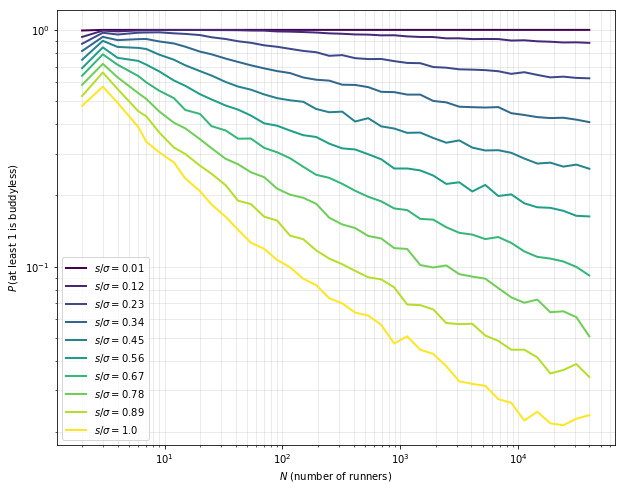

In [5]:
color_norm = mpl.colors.Normalize(vmin=s_over_sigs[0],vmax=s_over_sigs[-1])
cmap = plt.cm.get_cmap('viridis')
f, ax = plt.subplots(figsize=(10,8))
for idx,s_over_sig in enumerate(s_over_sigs):
    leg_text = '$s/\sigma = $'+str(s_over_sig)
    ax.loglog(n_vals,all_probs[idx,:],color=cmap(color_norm(s_over_sig)),label=leg_text,linewidth=2)
ax.legend()
ax.grid(which='both',alpha=.3)
ax.set_xlabel('$N$ (number of runners)')
ax.set_ylabel('$P\,$(at least 1 is buddyless)')

The above plot makes it clear that even for very wide buddy windows ($s/\sigma=1$), it takes a lot of runners (>10000) to ensure no one is lonely.

## Analytic approximation

I've tried a few ideas attempting to formally describe this probability, and they've all been wrong. This one, though, seems to (sort of) approach the results of the MC in the limit of high $N$.

The idea is actually inspired by some old-school particle physics statistics,
(https://arxiv.org/abs/physics/0203002)
but doesn't actually use any of the results, unfortunately.

To find the probability $P_N(s,N)$ that a single runner will have a buddy when she joins a group of $N-1$ runners, I scan a $2s$-width window over the real line, integrating the product of the runner speed PDF $\phi(z)$ and the probability that the window contains at least 1 buddy. That is:
$$P_N(s,N) = \int^\infty_{-\infty} dz \, \phi(z) \,P(\text{buddy}\in[z+s,z-s]\,|\,N)$$
$P(\text{buddy}\in[z+s,z-s]\,|\,N)$ is given by the Poisson PMF, where the mean is the integral of the normal distribution in the window range:

$$
\begin{align}
P(\text{buddy}\in[z+s,z-s]\,|\,N) &= 1 - \text{Poiss}\left(0\,\middle|\,\mu=(N-1)\int^{z+s}_{z-s} dz \, \phi(z)\right)\\
                              &= 1 - \exp\big( -(N-1)(\Phi(z+s) - \Phi(z-s))\big)
\end{align}
$$

where $\Phi(z)$ is the standard normal CDF. Now, here's where things get sketchy: to find the probability that *everyone* has a buddy, I simply treat this as a binomial process:

$$ P(\text{group contains buddyless} \,| \, N) = 1 - P_N(s,N)^N $$

This is (sort of) the probability being calculated by the MC sims, so we can compare directly. This approximation is clearly invalid for small $N$ because the trials are not independent. But it turns out to do ok at higher $N$.

### Define analytic functions

In [6]:
def pdf(x):
    return norm.pdf(x)

def cdf(x):
    return norm.cdf(x)

def prob_not0_in_window(x,s_over_sig,n):
    return 1-np.exp(-(n-1)*(cdf(x+s_over_sig) - cdf(x-s_over_sig)))

def prob_nth_has_buddy(s_over_sig,n):
    bound = np.max([10,s_over_sig])
    x = np.linspace(-bound,bound,num=100000)
    dx = x[1]-x[0]
    dprob = (pdf(x)*prob_not0_in_window(x,s_over_sig,n)) * dx
    return dprob.sum()

def prob_any_nobuddy(s_over_sig,n):
    return (1-np.power(prob_nth_has_buddy(s_over_sig,n),n))

### Estimate probabilities and compare to MC calculations

In [7]:
probs_ana = np.zeros_like(all_probs)
for s_idx,s_over_sig in enumerate(s_over_sigs):
    probs_ana[s_idx] = np.array([prob_any_nobuddy(s_over_sig=s_over_sig,n=n) for n in n_vals])

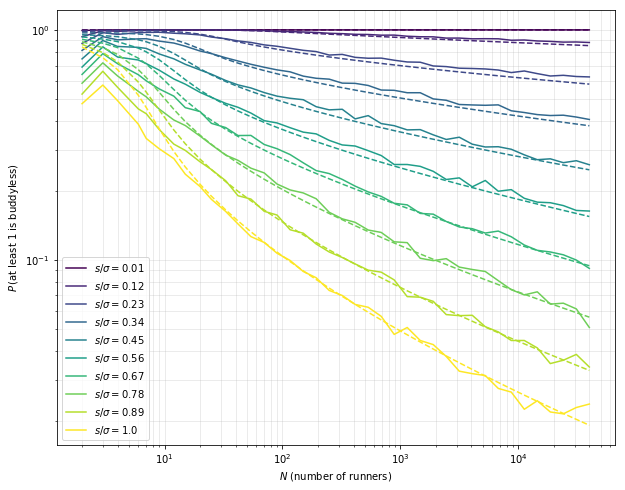

In [8]:
f, ax = plt.subplots(figsize=(10,8))
for idx,s_over_sig in enumerate(s_over_sigs):
    leg_text = '$s/\sigma = $'+str(s_over_sig)
    ax.loglog(n_vals,all_probs[idx,:],color=cmap(color_norm(s_over_sig)),label=leg_text,linewidth=1.5)
    ax.loglog(n_vals,probs_ana[idx,:],'--',color=cmap(color_norm(s_over_sig)),linewidth=1.5)
ax.legend()
ax.grid(which='both',alpha=.3)
ax.set_xlabel('$N$ (number of runners)')
ax.set_ylabel('$P\,$(at least 1 is buddyless)')

### Quick convergence check
The description clearly isn't perfect, but it does remarkably well at high N

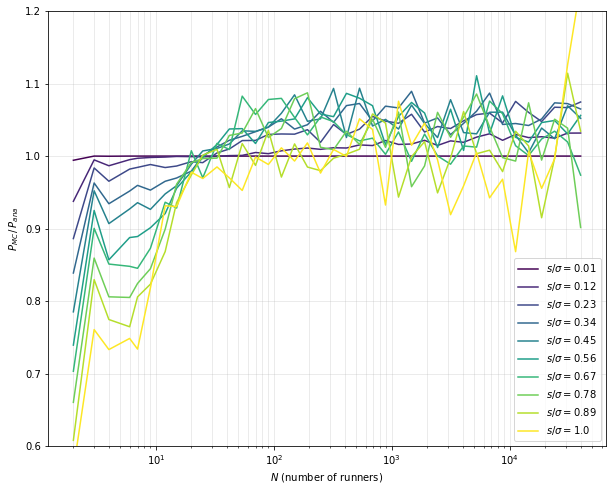

In [9]:
f, ax = plt.subplots(figsize=(10,8))
for idx,s_over_sig in enumerate(s_over_sigs):
    leg_text = '$s/\sigma = $'+str(s_over_sig)
    ax.plot(n_vals,all_probs[idx,:]/probs_ana[idx,:],color=cmap(color_norm(s_over_sig)),label=leg_text,linewidth=1.5)
ax.legend()
ax.set_ylim([.6,1.2]);
ax.set_xscale('log')
ax.grid(which='both',alpha=.3)
ax.set_xlabel('$N$ (number of runners)')
ax.set_ylabel('$P_{MC}\,/\,P_{ana}$')

## Extrapolating from fits to the MC data

The above analytic approach is fun, but unwieldy, and I'm not sure how it behaves at even higher N. Let's just fit a power law to the log-log probability curves obtained from the MC sims:

$$ \ln P  = a \, (\ln N)^b + c$$

I'll restrict the fit to $N>20$, to avoid the funky behavior for small group size.

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


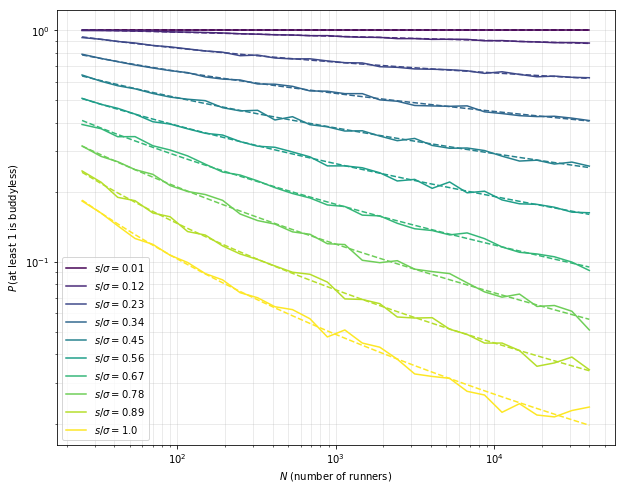

In [10]:
def fit_func(x, a, b, c):
     return a*np.power(x,b)+c

n_min = 20
p_fits = np.zeros((np.size(s_over_sigs),3))
x_data = np.log(n_vals[n_vals>n_min])

f, ax = plt.subplots(figsize=(10,8))

for idx,s_over_sig in enumerate(s_over_sigs):
    y_data = np.log(all_probs[idx,n_vals>n_min])
    p_fit,p_cov = curve_fit(fit_func,x_data,y_data)
    leg_text = '$s/\sigma = $'+str(s_over_sig)
    ax.loglog(np.exp(x_data),np.exp(y_data),color=cmap(color_norm(s_over_sig)),label=leg_text,linewidth=1.5)
    ax.loglog(np.exp(x_data),np.exp(fit_func(x_data,*p_fit)),'--',color=cmap(color_norm(s_over_sig)),linewidth=1.5)
    p_fits[idx] = p_fit
    
ax.grid(which='both',alpha=.3)
ax.set_xlabel('$N$ (number of runners)')
ax.set_ylabel('$P\,$(at least 1 is buddyless)')
ax.legend()

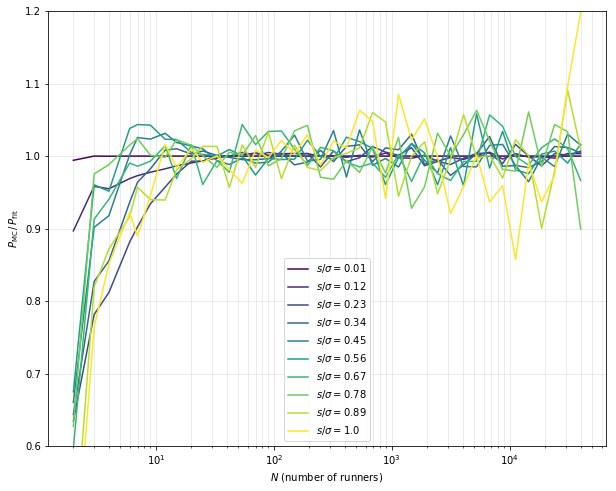

In [11]:
f, ax = plt.subplots(figsize=(10,8))
for idx,s_over_sig in enumerate(s_over_sigs):
    leg_text = '$s/\sigma = $'+str(s_over_sig)
    ax.plot(n_vals,all_probs[idx,:]/np.exp(fit_func(np.log(n_vals),*(p_fits[idx,:]))),
            color=cmap(color_norm(s_over_sig)),label=leg_text,linewidth=1.5)
ax.legend()
ax.set_ylim([.6,1.2]);
ax.set_xscale('log')
ax.grid(which='both',alpha=.3)
ax.set_xlabel('$N$ (number of runners)')
ax.set_ylabel('$P_{\mathrm{MC}}\,/\,P_{\mathrm{fit}}$')

So the power-law description looks pretty good. Now, we can finally take a shot at estimating when 99% of running groups have no lonely runners (or equivalently, where our $P = .01$).

To back this out of the fit results, we use the inverse function:

$$ \ln N = \left(\frac{\ln P - c}{a}\right)^{1/b} $$


In [12]:
def inverse_fit_func(y,par):
    #a*np.power(x,b)+c
    return np.power((y-par[2])/par[0],1/par[1])

So how many runners do we need for the $s/\sigma=1$ case?

In [13]:
np.exp(inverse_fit_func(np.log(.01),p_fits[9]))

1340892.9901995994

A lot! Over a million. But it makes sense, looking at our simulation results and extrapolating by eye. We can cross-check against our weird analytic function:

In [17]:
prob_any_nobuddy(s_over_sig=1,n=1340893)

0.0090627854139174735

And we can cross-check against a simulation run:

In [19]:
probs_mc(s_over_sig=1,n_vals=[1340893],n_trials=1000)

Simulating 400000000 total runners
Done simulating runners. Breaking up into trials.
chunk size = 298
chunk size = 298
chunk size = 298
chunk size = 106


array([ 0.004])

Looks like maybe our estimate is a little conservative, but it's in the ballpark. Now, how about for the more realistic cases where $s/\sigma < 1$?

s/sig = 0.34
   log_10(N) = 73.7464763387
s/sig = 0.45
   log_10(N) = 29.3983525258
s/sig = 0.56
   log_10(N) = 18.369218157
s/sig = 0.67
   log_10(N) = 13.2529601148
s/sig = 0.78
   log_10(N) = 9.49629928471
s/sig = 0.89
   log_10(N) = 7.94586375294
s/sig = 1.0
   log_10(N) = 6.12739412042


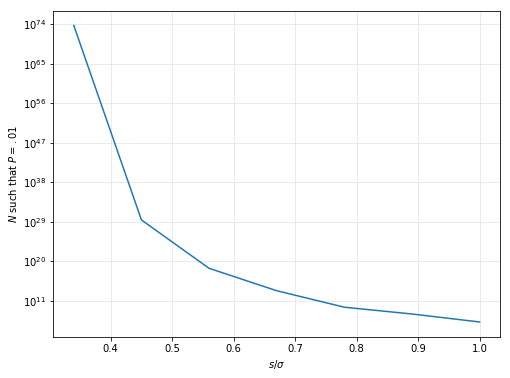

In [16]:
f, ax = plt.subplots(figsize=(8,6))

N99 = np.zeros_like(s_over_sigs)
for idx,s_over_sig in enumerate(s_over_sigs):
    if s_over_sig < .3: # fits unreliable
        N99[idx] = np.nan
        continue
    target = np.log(.01)
    N99[idx] = np.exp(inverse_fit_func(target,p_fits[idx]))
    print('s/sig = '+str(s_over_sig))
    print('   log_10(N) = '+ str(np.log10(N99[idx])))
    
ax.plot(s_over_sigs,N99)
ax.set_yscale('log')
ax.set_xlabel('$s/\sigma$')
ax.set_ylabel('$N$ such that $P=.01$')
ax.grid(which='major',alpha=0.3)

Yikes. So if $s/\sigma \approx 2/3$, then all of the ants in the world would have to participate in a marathon for there to be a 99% chance that every one of them had a buddy. (source: http://www.bbc.com/news/magazine-29281253)